In [1]:
import os
from core.project import Project
from utils.config import DEFAULT_LITHO_LEXICON, DEFAULT_LITHO_LEGEND, DEFAULT_BOREHOLE_LEGEND

In [2]:
from core.orm import Base
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from utils.visual import legend_from_attributes # une legende par défaut devrait être charge si aucune n'est passée issue #113

In [3]:
pollutants = ['Chlorure', 'PCB_28', 'PCB_138', 'PCB_118', 'BTEX_tot', 'S_tot', 'PCB_tot', 'PCB_180', 'PCB_101',
              'PCB_153', 'PCB_52', 'MTBE', 'Pyr', 'Bnz', 'Alp_C6-C8', 'Toln', 'Pb', 'Bnz(ghi)peryl', 'CN_cplx',
              'Cr_VI', 'Cis-1.2-DCEn', 'Ar_C6-C7', 'Cd', 'Phenol', '1.2-DCE', 'CN_libre', 'Bnz(a)pyr', 'Cu', 
              'Bnz(k)flranth', 'Anthrc', 'C16-C21', '1.1-DCEn', 'Chloroforme', 'Styr', 'Ni', 'EOX', 'Naphta', 
              'DCM', '1.1-DCE', 'C5-C8', 'As', '1.1.2-TCE', 'Bnz(b)flranth', 'Cr', 'HC_tot_C10-C40', 'HAP_tot_EPA', 
              'Co', 'Phenanthr', 'CN_tot', 'C12-C16', 'TCEyn', '(cis.trans)-1.2-DCEn_tot', 'Alp_C5-C6', 'Chrys', 
              'Trans-1.2-DCEyl', '1.2-DCP', 'Ar_C7-C8', '1.1.1-TCE', 'Zn', 'Indeno(1.2.3-cd)pyr', 'Alp_C8-C10', 
              'Flranth', 'HC_tot_C10-C35', 'Acenaphtyl', 'C8-C10', 'Bnz(a)anthrc', 'Dibnz(ah)anthrc', 'Hg', 
              'Ar_C8-C10', 'C10-C12', 'C35-C40', 'P-M-Xyl', 'CVinyl', 'Acenaphtn', 'TetraCEyn', 'Xyl', 'C21-C35', 
              'TCM', 'O-Xyl']
legend_dict = legend_from_attributes([('lithology', DEFAULT_LITHO_LEGEND), ('borehole_type', DEFAULT_BOREHOLE_LEGEND)])

In [4]:
legend_dict.keys()

dict_keys(['lithology', 'borehole_type'])

In [5]:
db_name = './new_db.db'
if os.path.exists(db_name):
    os.remove(db_name)

In [6]:
# This should become a constructor of Project (use polymorphism)
def load(db_name, **kwargs):
    """ loads a project from a project database"""
    legend_dict = kwargs.pop('legend_dict', legend_from_attributes([('lithology', DEFAULT_LITHO_LEGEND)]))
    litho_lexicon = kwargs.pop('litho_lexicon', None)
    project_name = kwargs.pop('project_name', db_name.rstrip('.db'))
    verbose = kwargs.pop('verbose', False)
    
    engine = create_engine(f"sqlite:///{db_name}", echo=verbose)
    Base.metadata.create_all(engine)
    Session = sessionmaker(bind=engine)
    session = Session()
    if verbose:
        print(f'legend_dict: {legend_dict}')
    p = Project(session, name=project_name, legend_dict=legend_dict, lexicon=litho_lexicon)
    p.refresh()
    session.close()
    return p

## Create a new project from an empty database

In [7]:
p = load(db_name, legend_dict=legend_dict, verbose=False)
#p.plot_3d( window_size=(800, 600))

/home/su530201/PycharmProjects/GSDMA/core/project.py:76: SAWarning: relationship 'ComponentOrm.intervals' will copy column Components.id to column Linkintervalcomponent.comp_id, which conflicts with relationship(s): 'IntervalOrm.components' (copies Components.id to Linkintervalcomponent.comp_id). If this is not the intention, consider if these relationships should be linked with back_populates, or if viewonly=True should be applied to one or more if they are read-only. For the less common case that foreign key constraints are partially overlapping, the orm.foreign() annotation can be used to isolate the columns that should be written towards.   To silence this warning, add the parameter 'overlaps="components"' to the 'ComponentOrm.intervals' relationship. (Background on this error at: https://sqlalche.me/e/14/qzyx)
  self.boreholes_orm = self.session.query(BoreholeOrm).all()
/home/su530201/PycharmProjects/GSDMA/core/project.py:76: SAWarning: relationship 'ComponentOrm.intervals' will c

In [8]:
from core.orm import BoreholeOrm, IntervalOrm, PositionOrm, ComponentOrm, LinkIntervalComponentOrm

In [9]:
# This function should be converted into a method of Project
def insert_borehole(project, bh_dict, verbose=True):
    bh_orm = BoreholeOrm(id=bh_dict['id'], date=bh_dict.pop('date', None), length=bh_dict.pop('length', None), diameter=bh_dict.pop('diameter', None))
    intv_id = project.find_next_id(IntervalOrm)
    bh_orm.intervals_values.update({intv_id: {'description' : f"{bh_dict['borehole_type']} {bh_dict['id']}",
                                'interval_number': 0,
                                'top': PositionOrm(**bh_dict['top']),
                                'base': PositionOrm(**bh_dict['base'])}})
    
    component_id = project.find_next_id(ComponentOrm)
    bh_component = ComponentOrm(id=component_id, description="{'borehole_type': '" + bh_dict['borehole_type'] + "'}")
    
    # TODO verify if component is already present
    project.session.add(bh_component)
    
    link_dict = {(intv_id, component_id): {'extra_data': 'None'}}
    print(f'interval : {intv_id}, component: {component_id}')
    project.add_link_components_intervals(link_dict)
    project.commit()
    project.add_borehole(bh_orm, verbose)

In [10]:
insert_borehole(p, {'id':'F201', 'borehole_type': 'piezometer', 'length': 18, 'diameter':0.1, 'top':{'middle': 100., 'x': 152890., 'y': 122596.}, 'base':{'middle': 90., 'x': 152890., 'y': 122596.}})

interval : 0, component: 0
Boreholes in the project :  0
Boreholes in the project :  0
Boreholes in the project :  0
Borehole geometry created successfully !

F201  added


/home/su530201/.local/share/virtualenvs/GSDMA-tJb-HgI6/lib/python3.8/site-packages/pyvista/core/dataset.py:1332: PyvistaDeprecationWarning: Use of `cell_arrays` is deprecated. Use `cell_data` instead.
  warnings.warn(


In [11]:
intv_dict={'bh_id': 0, 'description': 'sable grossier à la base et plus fin vers le haut',
           'interval_number': 1,
           'top':{'middle': 100., 'x': 152890., 'y': 122596.},
           'base':{'middle': 94., 'x': 152890., 'y': 122596.},
           'components':["{'lithology': 'sable'}", "{'benzene_industrial': 'VI'}"]
          }

In [12]:
def insert_interval_in_borehole(project, intv_dict):
    intv_id = project.find_next_id(IntervalOrm)
    print(intv_dict['bh_id'])
    project.boreholes_orm[intv_dict['bh_id']].intervals_values.update({
                                intv_id: {'description' : intv_dict['description'],
                                'interval_number': intv_dict['interval_number'],
                                'top': PositionOrm(**intv_dict['top']),
                                'base': PositionOrm(**intv_dict['base'])}})
    link_dict={}
    for descr_comp in intv_dict['components']:
        component_id = project.find_next_id(ComponentOrm)
        new_component = ComponentOrm(id=component_id, description=descr_comp)
        print(descr_comp)
    
        # TODO verify if component is already present
        project.session.add(new_component)
        link_dict.update({(intv_id, component_id): {'extra_data': 'None'}})
        print(f'interval : {intv_id}, component: {component_id}')
    project.add_link_components_intervals(link_dict)

In [13]:
insert_interval_in_borehole(p, intv_dict)

0
{'lithology': 'sable'}
interval : 1, component: 1
{'benzene_industrial': 'VI'}
interval : 1, component: 2
Boreholes in the project :  1


In [14]:
p.refresh(update_3d=True)

Borehole geometry created successfully !



In [15]:
p.update_legend_cmap(compute_all_attrib=True, legend_dict=legend_dict)

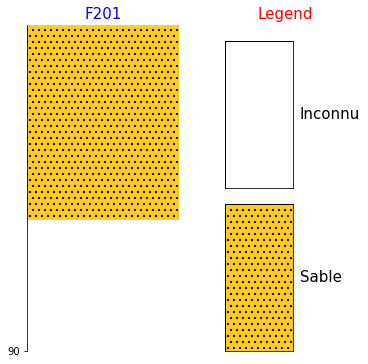

In [16]:
p.boreholes_3d[0].plot_log(repr_attribute='lithology')

In [17]:
p.plot_3d(window_size=(800, 600), repr_attribute='lithology', str_annotations=True, verbose=True)

Borehole "F201" | attribute values -> ['Inconnu', 'sable']


In [18]:
p.plot_3d(window_size=(800, 600), repr_attribute='borehole_type', str_annotations=False, verbose=True)

Borehole "F201" | attribute values -> ['piezometer', 'Inconnu']


# Tests

In [19]:
p.legend_dict

{'lithology': {'legend': Legend(Decor({'_colour': '#ffffff', 'width': 3, 'hatch': None, 'component': Component({'lithology': 'Inconnu'})})
  Decor({'_colour': '#ffcb23', 'width': 3, 'hatch': "'..'", 'component': Component({'lithology': 'sable'})})),
  'cmap': <matplotlib.colors.ListedColormap at 0x7f21628244c0>,
  'values': ['Inconnu', 'sable']},
 'borehole_type': {'legend': Legend(Decor({'_colour': '#888888', 'width': 3, 'component': Component({'borehole_type': 'piezometer'}), 'hatch': None})),
  'cmap': <matplotlib.colors.ListedColormap at 0x7f2162826c40>,
  'values': ['piezometer', 'Inconnu']}}

In [20]:
p.boreholes_3d[0]

<core.visual.Borehole3D> Borehole with 3 Intervals | start=90.0, stop=100.0 | name: F201